In [1]:
!pip install kagglehub lxml tensorflow

import kagglehub
import os

dataset_path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
print("Dataset path:", dataset_path)

Dataset path: /kaggle/input/face-mask-detection


In [2]:
import os, cv2, random
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub
from google.colab import files

In [3]:
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
image_dir = os.path.join(path, "images")
annotation_dir = os.path.join(path, "annotations")
CLASSES = ['with_mask', 'without_mask', 'mask_weared_incorrect']
IMAGE_SIZE = 224

In [4]:
def load_data(image_dir, annotations_dir):
    data_by_class = defaultdict(list)
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith(".xml"): continue
        tree = ET.parse(os.path.join(annotations_dir, xml_file))
        root = tree.getroot()
        filename = root.find('filename').text
        img_path = os.path.join(image_dir, filename)
        image = cv2.imread(img_path)
        if image is None: continue
        h, w = image.shape[:2]
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        for obj in root.findall('object'):
            label = obj.find('name').text
            if label not in CLASSES: continue
            box = obj.find('bndbox')
            x1 = int(box.find('xmin').text) / w
            y1 = int(box.find('ymin').text) / h
            x2 = int(box.find('xmax').text) / w
            y2 = int(box.find('ymax').text) / h
            class_id = CLASSES.index(label)
            data_by_class[class_id].append((image, [x1, y1, x2, y2], class_id))
    return data_by_class

def oversample(data_by_class, target_class, times):
    samples = data_by_class[target_class]
    data_by_class[target_class] = samples * times
    return data_by_class

data_by_class = load_data(image_dir, annotation_dir)
data_by_class = oversample(data_by_class, target_class=2, times=2)

all_data = []
for cls, samples in data_by_class.items():
    all_data.extend(samples)
random.shuffle(all_data)

images, bboxes, labels = [], [], []
for img, box, cls in all_data:
    images.append(img)
    bboxes.append(box)
    labels.append(tf.keras.utils.to_categorical(cls, num_classes=3))

images = np.array(images) / 255.0
bboxes = np.array(bboxes)
labels = np.array(labels)

In [5]:
X_train, X_test, y_train_box, y_test_box, y_train_label, y_test_label = train_test_split(
    images, bboxes, labels, test_size=0.2, random_state=42)

del images, bboxes, labels
import gc
gc.collect()

6

In [6]:
base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base.output)
bbox = Dense(4, name='bbox')(x)
class_output = Dense(3, activation='softmax', name='class_output')(x)
model = Model(inputs=base.input, outputs=[bbox, class_output])
model.compile(
    optimizer='adam',
    loss={'bbox': 'mse', 'class_output': 'categorical_crossentropy'},
    metrics={'bbox': 'mse', 'class_output': 'accuracy'}
)

In [8]:
def data_generator(X, y_box, y_label, batch_size=4):
    while True:
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], {
                'bbox': y_box[i:i+batch_size],
                'class_output': y_label[i:i+batch_size]
            }

train_gen = data_generator(X_train, y_train_box, y_train_label)
val_gen = data_generator(X_test, y_test_box, y_test_label)

steps_per_epoch = len(X_train) // 4
val_steps = len(X_test) // 4

early_stop = EarlyStopping(monitor='val_class_output_accuracy', patience=3, mode='max', restore_best_weights=True)

model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
839/839 ━━━━━━━━━━━━━━━━━━━━ 876s 1s/step - bbox_loss: 0.0596 - bbox_mse: 0.0596 - class_output_accuracy: 0.7787 - class_output_loss: 0.6678 - loss: 0.7274 - val_bbox_loss: 0.1305 - val_bbox_mse: 0.1305 - val_class_output_accuracy: 0.7739 - val_class_output_loss: 0.9054 - val_loss: 1.0359
Epoch 2/30
839/839 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - bbox_loss: 0.0561 - bbox_mse: 0.0561 - class_output_accuracy: 0.7811 - class_output_loss: 0.6565 - loss: 0.7126 - val_bbox_loss: 0.1408 - val_bbox_mse: 0.1408 - val_class_output_accuracy: 0.5778 - val_class_output_loss: 0.9746 - val_loss: 1.1154
Epoch 3/30
839/839 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - bbox_loss: 0.0550 - bbox_mse: 0.0550 - class_output_accuracy: 0.7795 - class_output_loss: 0.6462 - loss: 0.7012 - val_bbox_loss: 0.0641 - val_bbox_mse: 0.0641 - val_class_output_accuracy: 0.7713 - val_class_output_loss: 0.7114 - val_loss: 0.7762
Epoch 4/30
839/839 ━━━━━━━━━━━━━━━━━━━━ 870s 1s/step - bbox_loss: 0.0537 - bbox_mse: 0.0537 - cla

In [9]:
pred_bb, pred_cls = model.predict(X_test)
y_pred = np.argmax(pred_cls, axis=1)
y_true = np.argmax(y_test_label, axis=1)

print("\nClassification Report at IoU=0.5:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

Classification Report at IoU=0.5:

                       precision    recall  f1-score   support

            with_mask       0.77      1.00      0.87       650
         without_mask       0.00      0.00      0.00       141
mask_weared_incorrect       0.00      0.00      0.00        48

             accuracy                           0.77       839
            macro avg       0.26      0.33      0.29       839
         weighted avg       0.60      0.77      0.68       839



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


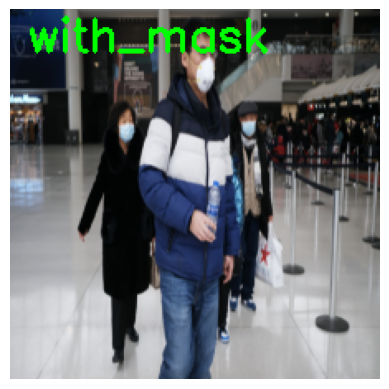

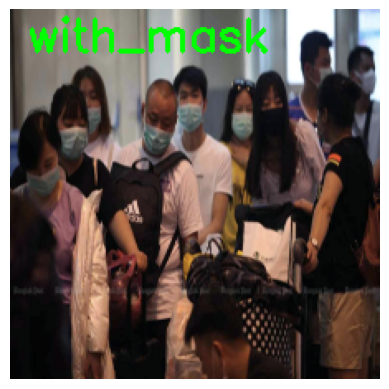

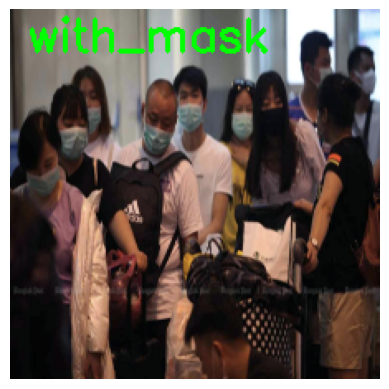

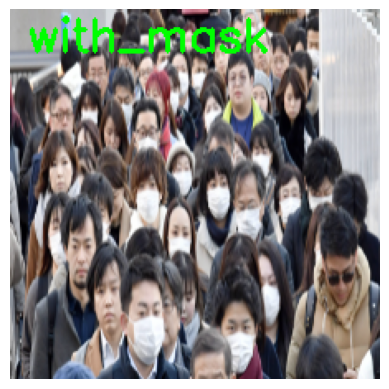

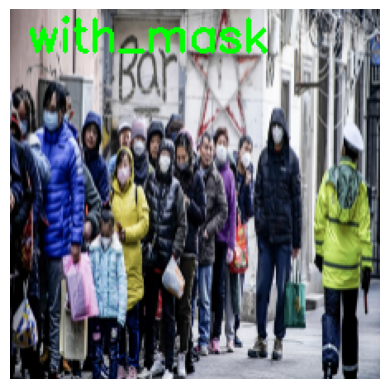

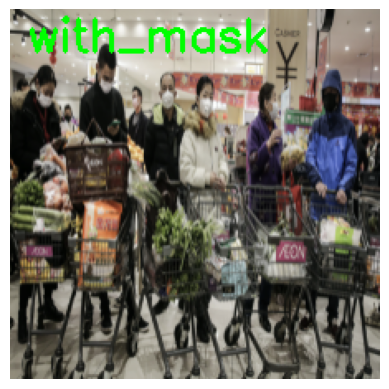

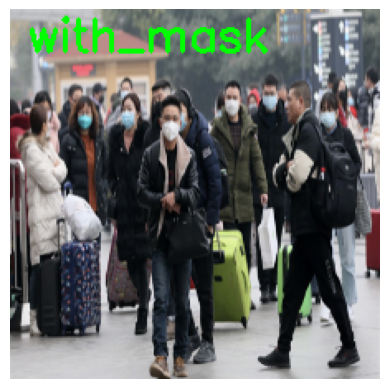

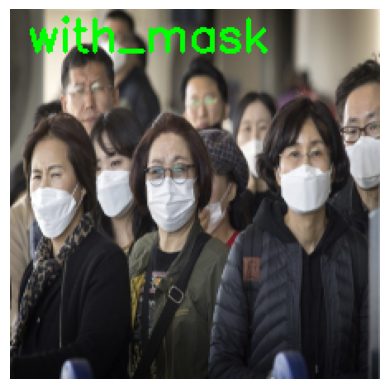

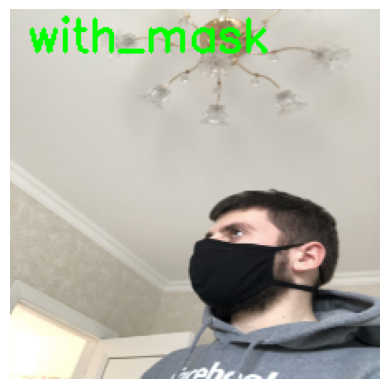

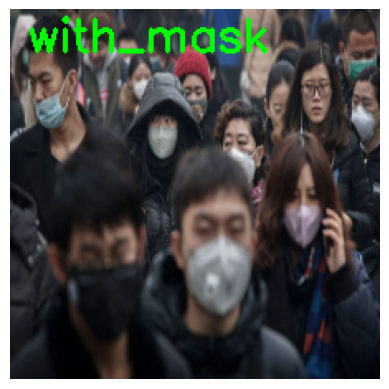

In [15]:
indices = random.sample(range(len(X_test)), 10)

for idx in indices:
    img = X_test[idx]
    pred_box = pred_bb[idx]
    pred_class = np.argmax(pred_cls[idx])

    if img.shape[:2] != (224, 224):
        print(f"Warning: Image shape is {img.shape[:2]} not (224, 224)")
        img = cv2.resize((img * 255).astype(np.uint8), (224, 224))
    else:
        img = (img * 255).astype(np.uint8)

    img_copy = img.copy()

    cv2.putText(img_copy, CLASSES[pred_class], (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
model.save("face_mask_detector.h5")
model.save("face_mask_detector.keras")
model.export("face_mask_detector_savedmodel")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("face_mask_detector.tflite", "wb") as f:
    f.write(tflite_model)

files.download("face_mask_detector.h5")
files.download("face_mask_detector.keras")
!zip -r face_mask_detector_savedmodel.zip face_mask_detector_savedmodel
files.download("face_mask_detector_savedmodel.zip")
files.download("face_mask_detector.tflite")

Saved artifact at 'face_mask_detector_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  140166322927376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166318392912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166318393488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166322927760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166322928144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166322928336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166318392528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166318391760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140166318393680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401663

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: face_mask_detector_savedmodel/ (stored 0%)
  adding: face_mask_detector_savedmodel/assets/ (stored 0%)
  adding: face_mask_detector_savedmodel/saved_model.pb (deflated 90%)
  adding: face_mask_detector_savedmodel/variables/ (stored 0%)
  adding: face_mask_detector_savedmodel/variables/variables.index (deflated 78%)
  adding: face_mask_detector_savedmodel/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: face_mask_detector_savedmodel/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>